<a href="https://colab.research.google.com/github/almendruki/Cosas-TDA/blob/main/Almendra_Orellana_Figueroa_Clase_6_Tutorial_classificacion_usando_descriptores_topol%C3%B3gicos_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Clasificación de Dígitos MNIST usando Descriptores Topológicos (componentes conectadas y ciclos)

**Objetivo**: Usar componentes conectadas y ciclos como características para clasificar dígitos manuscritos, comparando el rendimiento antes y después de reducción de dimensiones.



### Parte 1: Preparación del Dataset MNIST

Dataset: 500 imágenes de 784 píxeles
Distribución por dígito: [49 60 56 38 56 42 42 54 59 44]


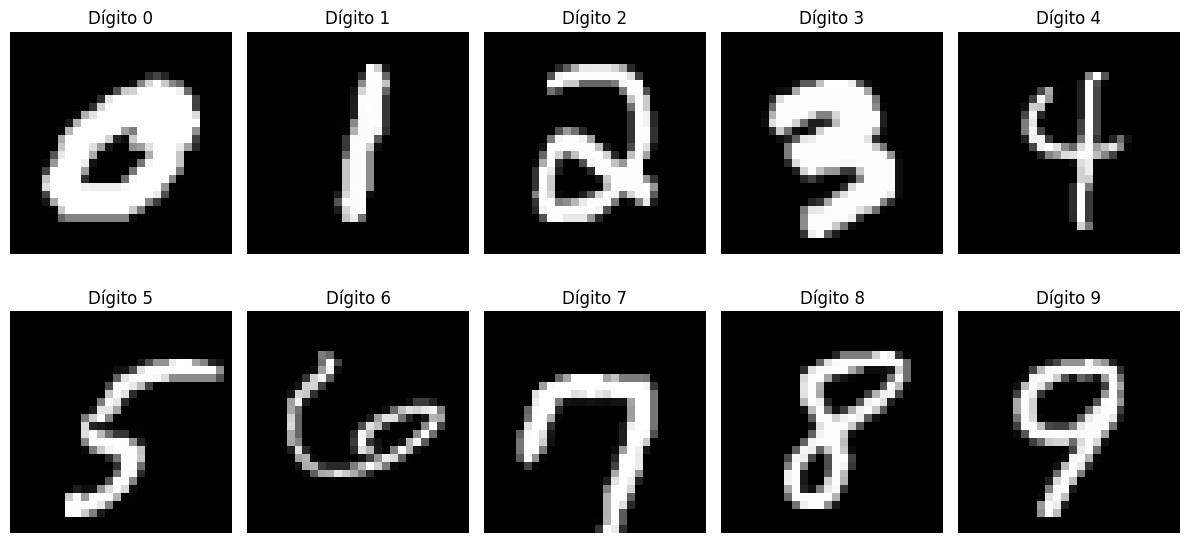

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Configuración para visualización
plt.rcParams['figure.figsize'] = (12, 8)


# Cargar MNIST (usar muestra para eficiencia)
mnist = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X, y = mnist

# Tomar una muestra estratificada para eficiencia
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.95, random_state=42)
_, sample_idx = next(splitter.split(X, y))  # obtiene los indices del conjunto de prueba de la muestra estratificada
X_sample = X[sample_idx][:500]  # 500 imágenes (aproximadamente 50 por dígito)
y_sample = y[sample_idx][:500]  # 500 etiquetas (correspondiente a cada imagen)

print(f"Dataset: {X_sample.shape[0]} imágenes de {X_sample.shape[1]} píxeles")
print(f"Distribución por dígito: {np.bincount(y_sample.astype(int))}")

# Visualizar algunos ejemplos
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    idx = np.where(y_sample.astype(int) == i)[0][0]
    ax = axes[i//5, i%5]
    ax.imshow(X_sample[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f'Dígito {i}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### Parte 2: Extracción de Descriptores Topológicos

Usamos algunos elementos de la clase 4 como:
* Cálculo de matriz distancia
* Generación de epsilons
* Encontrar componentes conectadas
* Encontrar ciclos

In [ ]:
from scipy.spatial.distance import pdist, squareform
import networkx as nx


def calcular_matriz_distancias(X):
    """Calcula la matriz de distancias euclidianas"""
    distancias = pdist(X, metric='euclidean')
    matriz_dist = squareform(distancias)
    return matriz_dist

def generar_epsilons(D, k=8):
    """Genera k valores de epsilon entre min y max distancias"""
    dist_min = D[D > 0].min()  # Mínima distancia no cero
    dist_max = D.max()         # Máxima distancia

    epsilons = np.linspace(dist_min, dist_max, k)
    return epsilons

def construir_grafo_epsilon(X, D, epsilon):
    """Construye un grafo donde hay arista si distancia <= epsilon"""
    n = len(X)
    G = nx.Graph()

    # Añadir nodos
    for i in range(n):
        G.add_node(i, pos=X[i])

    # Añadir aristas
    for i in range(n):
        for j in range(i + 1, n):
            if D[i, j] <= epsilon:
                G.add_edge(i, j)

    return G

def encontrar_componentes_conectadas(G):
    """Obtiene las componentes conectadas"""

    return nx.number_connected_components(G)

def encontrar_ciclos(G):
    """Obtiene los los ciclos en el grafo
      Utilizamos la formula de Euler para calcular el número de ciclos
      Pero se puede hacer con cualquier algoritmo de recorrido de grafos y la estructura union find
    """
    info_ciclos = []

    # Para contar ciclos independientes en un grafo conectado:
    # número de ciclos = número de aristas - número de nodos + número de componentes
    n_nodos = G.number_of_nodes()
    n_aristas = G.number_of_edges()
    n_componentes = nx.number_connected_components(G)

    # Número de ciclos independientes que se pueden formar
    num_ciclos = n_aristas - n_nodos + n_componentes

    return num_ciclos

Ahora obtenemos los descriptores topológicos más simples usado grafos

In [ ]:
def extraer_descriptores_topologicos(X, no_epsilons=8, verbose=False):
    """
    Extrae descriptores topológicos para cada imagen

    Returns:
    - descriptores: array de shape (n_samples, 2*no_epsilons)
      Cada fila contiene [componentes_ε1, ciclos_ε1, componentes_ε2, ciclos_ε2, ...]
    """
    n_samples = X.shape[0]
    n_features = 2 * no_epsilons  # componentes + ciclos para cada epsilon
    descriptores = np.zeros((n_samples, n_features))

    for i, imagen in enumerate(X):
        if verbose and i % 50 == 0:
            print(f"Procesando imagen {i+1}/{n_samples}")

        # Calcular matriz de distancias para esta imagen
        # Nota: Aquí podrías usar diferentes estrategias:
        # 1. Tratar píxeles como puntos en 2D con intensidad
        # 2. Usar patches de la imagen
        # 3. Usar coordenadas de píxeles no-cero

        # Estrategia simple: coordenadas de píxeles con alta intensidad
        imagen_2d = imagen.reshape(28, 28)
        coords = np.argwhere(imagen_2d > 0.5 * imagen_2d.max())  # Píxeles "activos"

        if len(coords) < 3:  # Si muy pocos píxeles activos
            continue

        # Tomar muestra si hay demasiados puntos
        if len(coords) > 100:
            indices = np.random.choice(len(coords), 100, replace=False)
            coords = coords[indices]

        # Calcular descriptores para esta imagen
        D = calcular_matriz_distancias(coords)
        epsilons = generar_epsilons(D, no_epsilons)

        for j, eps in enumerate(epsilons):
            grafoj = construir_grafo_epsilon(coords, D, eps)
            num_comp = encontrar_componentes_conectadas(grafoj)
            num_ciclos = encontrar_ciclos(grafoj)

            descriptores[i, 2*j] = num_comp      # Componentes para epsilon j
            descriptores[i, 2*j + 1] = num_ciclos # Ciclos para epsilon j

    return descriptores, epsilons

# Definir rango de epsilons (ajustar según la escala de los datos)
no_epsilons = 8  # 8 valores de epsilon

print("Extrayendo descriptores topológicos...")
descriptores_alta_dim, epsilons = extraer_descriptores_topologicos(X_sample, no_epsilons, verbose=True)

print(f"Descriptores extraídos: {descriptores_alta_dim.shape}")
print(f"Ejemplo de descriptores para primera imagen:")
print(f"Epsilons: {epsilons}")
print(f"[comp1, cicl1, comp2, cicl2, ...]: {descriptores_alta_dim[0]}")

Extrayendo descriptores topológicos...
Procesando imagen 1/500
Procesando imagen 51/500
Procesando imagen 101/500
Procesando imagen 151/500
Procesando imagen 201/500
Procesando imagen 251/500
Procesando imagen 301/500
Procesando imagen 351/500
Procesando imagen 401/500
Procesando imagen 451/500
Descriptores extraídos: (500, 16)
Ejemplo de descriptores para primera imagen:
Epsilons: [ 1.          3.63092683  6.26185367  8.8927805  11.52370734 14.15463417
 16.785561   19.41648784]
[comp1, cicl1, comp2, cicl2, ...]: [1.000e+01 1.800e+01 1.000e+00 5.900e+02 1.000e+00 1.453e+03 1.000e+00
 2.573e+03 1.000e+00 3.611e+03 1.000e+00 4.213e+03 1.000e+00 4.693e+03
 1.000e+00 4.851e+03]


### Parte 3: Clasificación con Descriptores de Alta Dimensión

Precisión con descriptores topológicos (alta dim): 0.440

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.62      0.87      0.72        15
           1       0.74      0.94      0.83        18
           2       0.30      0.35      0.32        17
           3       0.50      0.27      0.35        11
           4       0.39      0.41      0.40        17
           5       0.00      0.00      0.00        12
           6       0.11      0.08      0.09        13
           7       0.29      0.31      0.30        16
           8       0.53      0.56      0.54        18
           9       0.29      0.31      0.30        13

    accuracy                           0.44       150
   macro avg       0.38      0.41      0.39       150
weighted avg       0.39      0.44      0.41       150



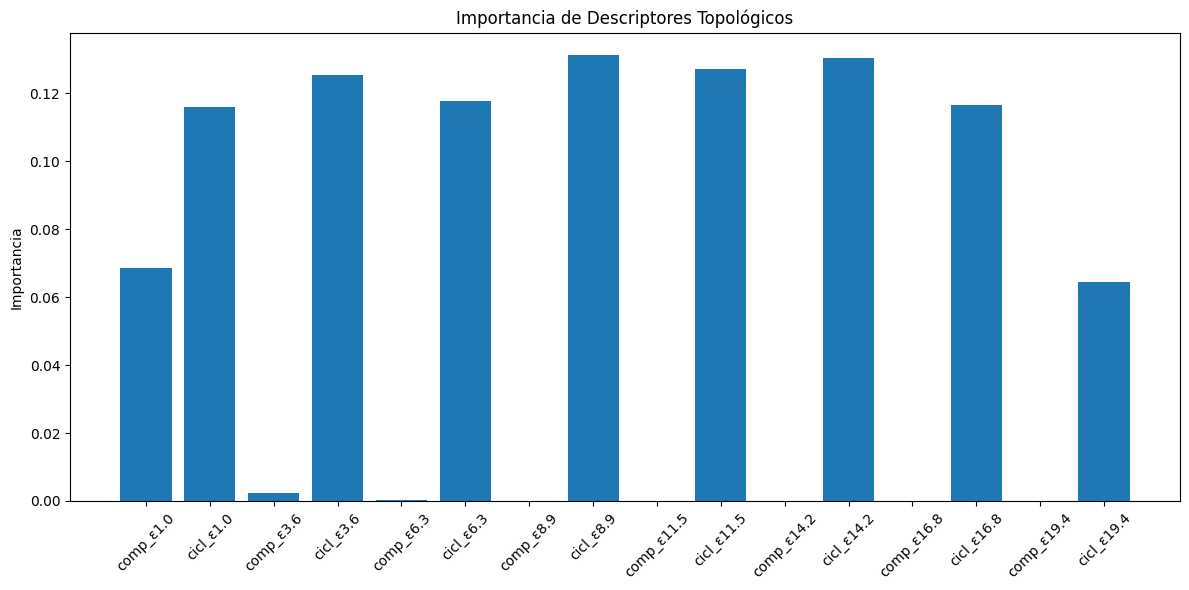

In [ ]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    descriptores_alta_dim, y_sample, test_size=0.3, random_state=42, stratify=y_sample
)

# Entrenar clasificador
clf_alta_dim = RandomForestClassifier(n_estimators=100, random_state=42)
clf_alta_dim.fit(X_train, y_train)

# Evaluar
y_pred_alta = clf_alta_dim.predict(X_test)
accuracy_alta = (y_pred_alta == y_test).mean()

print(f"Precisión con descriptores topológicos (alta dim): {accuracy_alta:.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_alta))

# Importancia de características
importancias = clf_alta_dim.feature_importances_
nombres_features = []
for i, eps in enumerate(epsilons):
    nombres_features.extend([f'comp_ε{eps:.1f}', f'cicl_ε{eps:.1f}'])

plt.figure(figsize=(12, 6))
plt.bar(nombres_features, importancias)
plt.xticks(rotation=45)
plt.title('Importancia de Descriptores Topológicos')
plt.ylabel('Importancia')
plt.tight_layout()
plt.show()


### Dejemos solo los ciclos y las componentes en epsilon 0

In [ ]:
n_features = 1+no_epsilons  # componentes + ciclos para cada epsilon
new_descriptores_alta = np.zeros((X_sample.shape[0], n_features))
for i, desc in enumerate(descriptores_alta_dim):
    new_descriptores_alta[i, 0] = desc[0]
    for j in range(no_epsilons):
        new_descriptores_alta[i, j+1] = desc[2*j+1]

print(f"Nuevos Descriptores extraídos: {new_descriptores_alta.shape}")
print(f"Ejemplo de descriptores para primera imagen:")
print(f"Epsilons: {epsilons}")
print(f"[comp1, cicl1, cicl2, cicl3, ...]: {new_descriptores_alta[0]}")

Nuevos Descriptores extraídos: (500, 9)
Ejemplo de descriptores para primera imagen:
Epsilons: [ 1.          3.63092683  6.26185367  8.8927805  11.52370734 14.15463417
 16.785561   19.41648784]
[comp1, cicl1, cicl2, cicl3, ...]: [  10.   18.  590. 1453. 2573. 3611. 4213. 4693. 4851.]


### y reclasificamos

Precisión con descriptores topológicos (nueva alta dim): 0.447

Reporte de clasificación :
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.71      0.83      0.77        18
           2       0.26      0.29      0.28        17
           3       0.29      0.18      0.22        11
           4       0.45      0.59      0.51        17
           5       0.00      0.00      0.00        12
           6       0.25      0.15      0.19        13
           7       0.26      0.31      0.29        16
           8       0.55      0.61      0.58        18
           9       0.33      0.31      0.32        13

    accuracy                           0.45       150
   macro avg       0.38      0.41      0.39       150
weighted avg       0.40      0.45      0.42       150



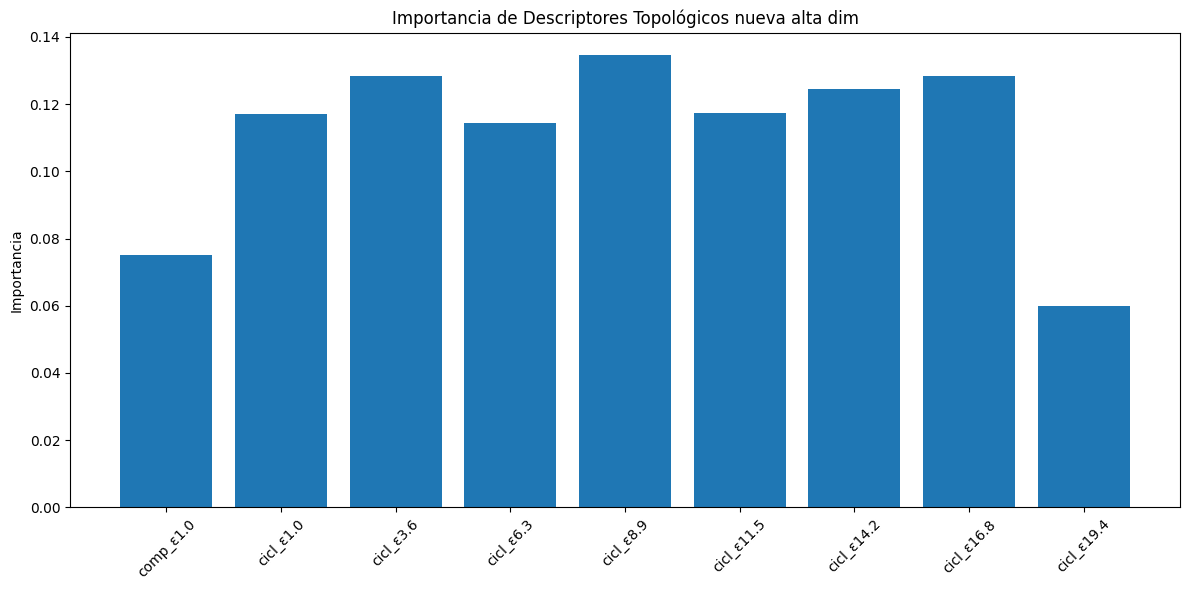

In [ ]:
# Dividir en entrenamiento y prueba
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    new_descriptores_alta, y_sample, test_size=0.3, random_state=42, stratify=y_sample
)

# Entrenar clasificador
clf_alta_new = RandomForestClassifier(n_estimators=100, random_state=42)
clf_alta_new.fit(X_train_new, y_train_new)

# Evaluar
y_pred_alta_new = clf_alta_new.predict(X_test_new)
accuracy_alta_new = (y_pred_alta_new == y_test_new).mean()

print(f"Precisión con descriptores topológicos (nueva alta dim): {accuracy_alta_new:.3f}")
print("\nReporte de clasificación :")
print(classification_report(y_test_new, y_pred_alta_new))

# Importancia de características
importancias_new = clf_alta_new.feature_importances_
nombres_features = [f'comp_ε{epsilons[0]:.1f}']
for i, eps in enumerate(epsilons):
    nombres_features.extend([f'cicl_ε{eps:.1f}'])

plt.figure(figsize=(12, 6))
plt.bar(nombres_features, importancias_new)
plt.xticks(rotation=45)
plt.title('Importancia de Descriptores Topológicos nueva alta dim')
plt.ylabel('Importancia')
plt.tight_layout()
plt.show()

### Parte 4: Reducción de Dimensiones y Re-clasificación

* Aplicamos PCA a las imágenes originales
* Se extraen los descriptores topológicos en 20d
* Clasificación de descriptores

Varianza explicada por PCA: 0.189


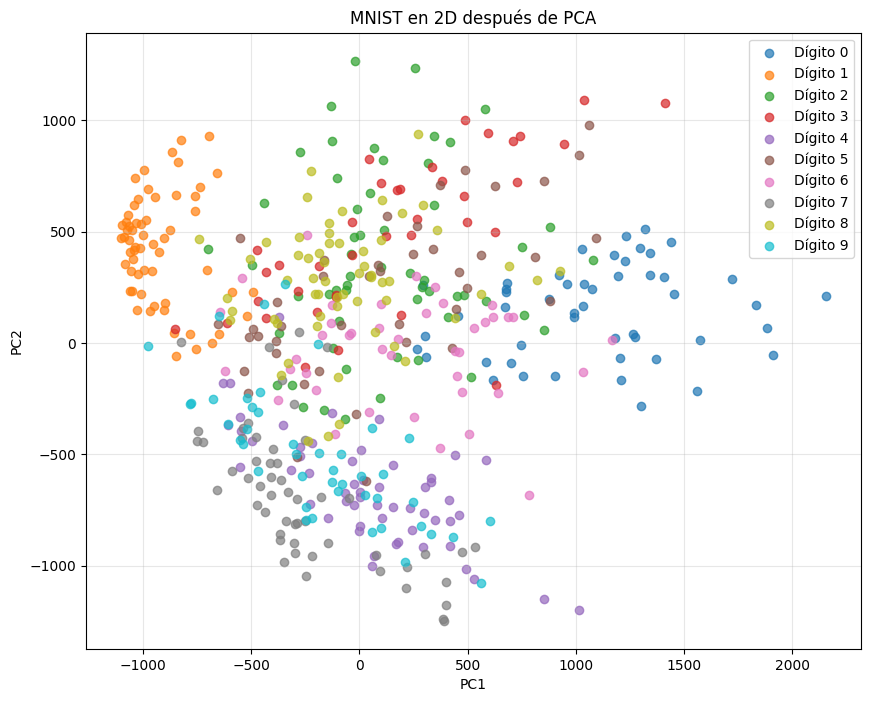

In [ ]:
from sklearn.decomposition import PCA

# Aplicar PCA a las imágenes originales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

print(f"Varianza explicada por PCA: {pca.explained_variance_ratio_.sum():.3f}")

# Visualizar datos en 2D por clase
plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for i in range(10):
    mask = y_sample.astype(int) == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=[colors[i]], label=f'Dígito {i}', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('MNIST en 2D después de PCA')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Precisión con descriptores topológicos (bajadim): 0.493

Reporte de clasificación en baja dim:
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.89      0.89      0.89        18
           2       0.33      0.35      0.34        17
           3       0.09      0.09      0.09        11
           4       0.50      0.53      0.51        17
           5       0.36      0.33      0.35        12
           6       0.23      0.23      0.23        13
           7       0.80      0.75      0.77        16
           8       0.38      0.33      0.35        18
           9       0.36      0.31      0.33        13

    accuracy                           0.49       150
   macro avg       0.46      0.47      0.46       150
weighted avg       0.49      0.49      0.49       150



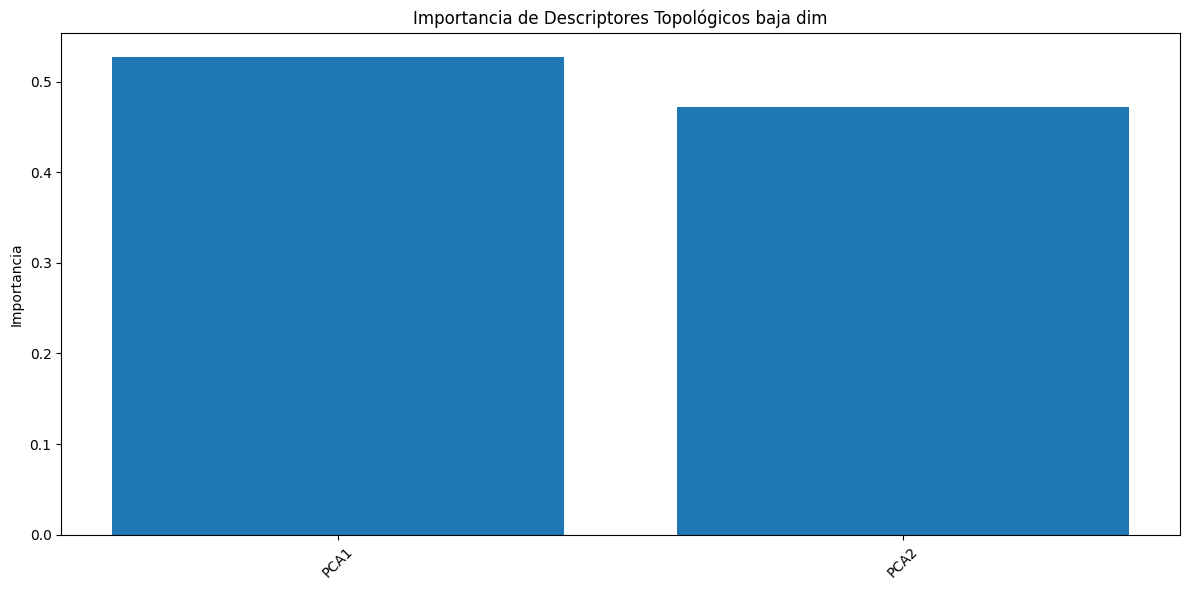

In [ ]:
# Clasificación con descriptores Baja dim
X_train_baja, X_test_baja, y_train_baja, y_test_baja = train_test_split(
    X_pca, y_sample, test_size=0.3, random_state=42, stratify=y_sample
)

clf_baja_dim = RandomForestClassifier(n_estimators=100, random_state=42)
clf_baja_dim.fit(X_train_baja, y_train_baja)
y_pred_baja = clf_baja_dim.predict(X_test_baja)
accuracy_baja = (y_pred_baja == y_test_baja).mean()

print(f"Precisión con descriptores topológicos (bajadim): {accuracy_baja:.3f}")
print("\nReporte de clasificación en baja dim:")
print(classification_report(y_test_baja, y_pred_baja))

# Importancia de características
importancias_baja = clf_baja_dim.feature_importances_
nombres_features = ["PCA1", "PCA2"]

plt.figure(figsize=(12, 6))
plt.bar(nombres_features, importancias_baja)
plt.xticks(rotation=45)
plt.title('Importancia de Descriptores Topológicos baja dim')
plt.ylabel('Importancia')
plt.tight_layout()
plt.show()


## Parte: Combinando descriptores topologicos con features de baja dimension

Precisión con descriptores topológicos (combinación de descriptores): 0.527

Reporte de clasificación de la combinación:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.90      1.00      0.95        18
           2       0.44      0.24      0.31        17
           3       0.29      0.36      0.32        11
           4       0.48      0.59      0.53        17
           5       0.14      0.08      0.11        12
           6       0.27      0.23      0.25        13
           7       0.53      0.56      0.55        16
           8       0.52      0.61      0.56        18
           9       0.42      0.38      0.40        13

    accuracy                           0.53       150
   macro avg       0.48      0.50      0.48       150
weighted avg       0.50      0.53      0.51       150



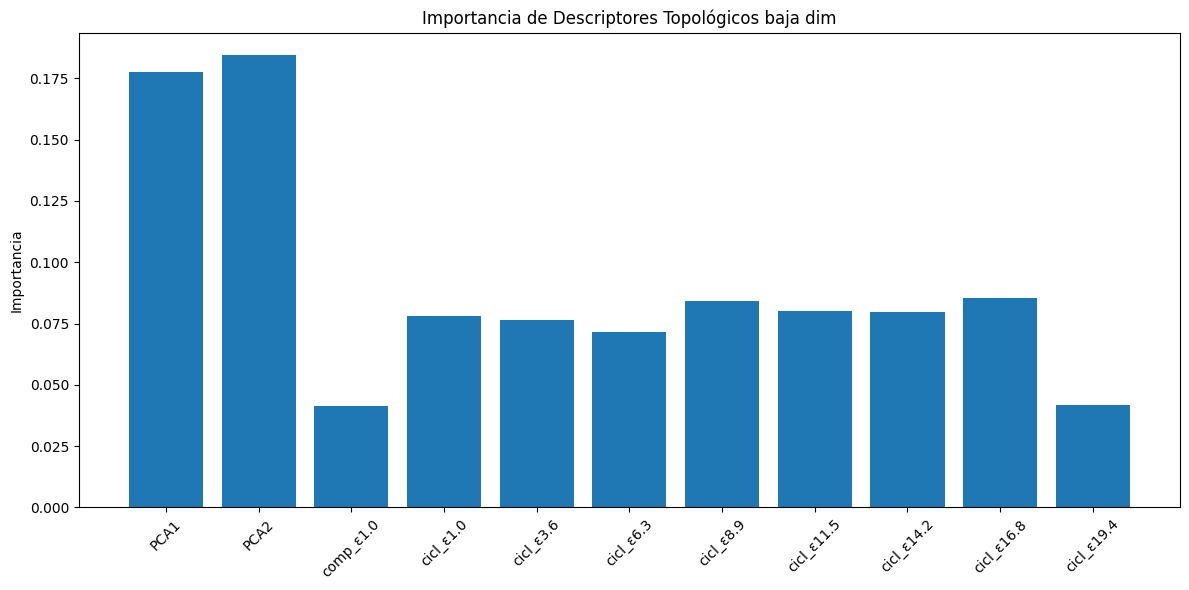

In [ ]:
X_comb = np.hstack((X_pca, new_descriptores_alta))
# Clasificación con descriptores Baja dim
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(
    X_comb, y_sample, test_size=0.3, random_state=42, stratify=y_sample
)

clf_comb = RandomForestClassifier(n_estimators=100, random_state=42)
clf_comb.fit(X_train_comb, y_train_comb)
y_pred_comb = clf_comb.predict(X_test_comb)
accuracy_comb = (y_pred_comb == y_test_comb).mean()

print(f"Precisión con descriptores topológicos (combinación de descriptores): {accuracy_comb:.3f}")
print("\nReporte de clasificación de la combinación:")
print(classification_report(y_test_comb, y_pred_comb))

# Importancia de características
importancias_comb = clf_comb.feature_importances_
nombres_features = ["PCA1", "PCA2"]
nombres_features.append(f'comp_ε{epsilons[0]:.1f}')
for i, eps in enumerate(epsilons):
    nombres_features.append(f'cicl_ε{eps:.1f}')

plt.figure(figsize=(12, 6))
plt.bar(nombres_features, importancias_comb)
plt.xticks(rotation=45)
plt.title('Importancia de Descriptores Topológicos baja dim')
plt.ylabel('Importancia')
plt.tight_layout()
plt.show()

### Parte 5: Análisis Comparativo y Visualización

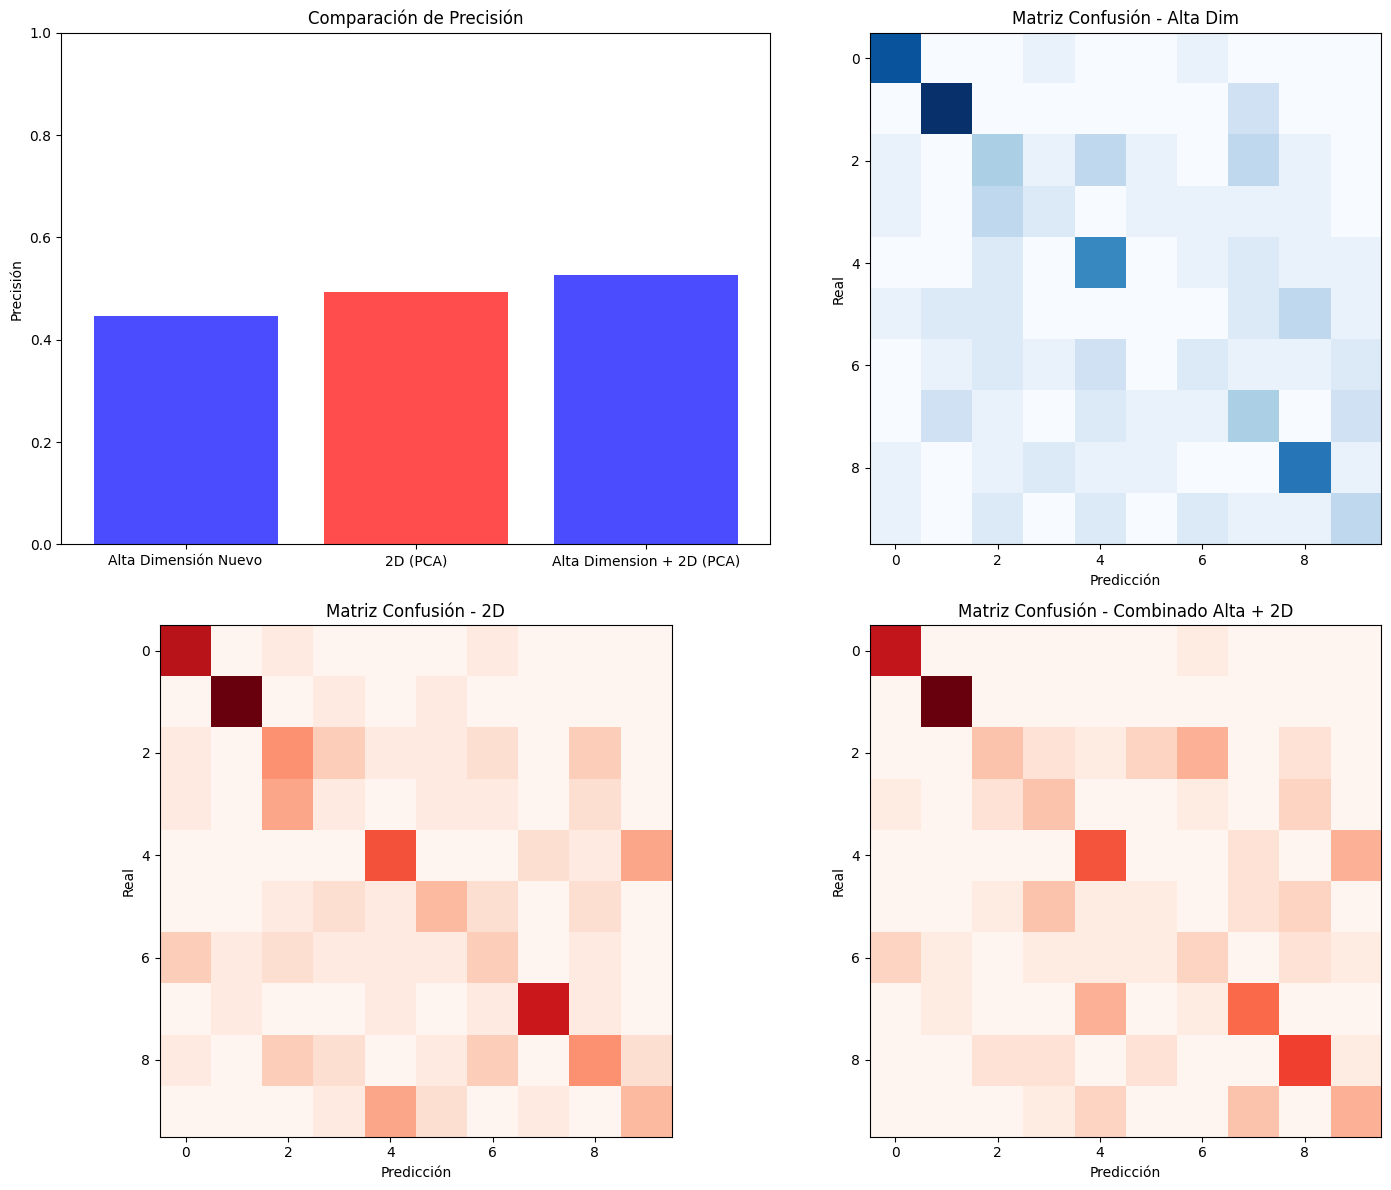

In [ ]:
def comparar_clasificaciones():
    # Comparar precisiones
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Precisión por método
    metodos = ['Alta Dimensión Nuevo', '2D (PCA)', 'Alta Dimension + 2D (PCA)']
    precisiones = [accuracy_alta_new, accuracy_baja, accuracy_comb]

    ax1.bar(metodos, precisiones, color=['blue', 'red'], alpha=0.7)
    ax1.set_ylabel('Precisión')
    ax1.set_title('Comparación de Precisión')
    ax1.set_ylim(0, 1)

    # Matriz de confusión - Alta dimensión
    cm_alta = confusion_matrix(y_test_new, y_pred_alta_new)
    im1 = ax2.imshow(cm_alta, cmap='Blues')
    ax2.set_title('Matriz Confusión - Alta Dim')
    ax2.set_xlabel('Predicción')
    ax2.set_ylabel('Real')

    # Matriz de confusión - Baja dimensión
    cm_baja = confusion_matrix(y_test_baja, y_pred_baja)
    im2 = ax3.imshow(cm_baja, cmap='Reds')
    ax3.set_title('Matriz Confusión - 2D')
    ax3.set_xlabel('Predicción')
    ax3.set_ylabel('Real')

    # Matriz de confusión - combinados dimensión
    cm_baja = confusion_matrix(y_test_comb, y_pred_comb)
    im3 = ax4.imshow(cm_baja, cmap='Reds')
    ax4.set_title('Matriz Confusión - Combinado Alta + 2D')
    ax4.set_xlabel('Predicción')
    ax4.set_ylabel('Real')



    plt.tight_layout()
    plt.show()

comparar_clasificaciones()

### Preguntas Guía Específicas

1. **Interpretabilidad**: ¿Puedes explicar por qué ciertos dígitos tienen más/menos componentes o ciclos? ¿Explique intuitivamente por qué en la clasificación topológica el dígito 5 se confunde con otros? ¿qué ocurre con el 4, 6, 9?

2. **Robustez**: ¿Cómo afecta el ruido en las imágenes a los descriptores topológicos?

3. **Escalabilidad**: ¿Es este enfoque viable para datasets más grandes?

4. **Comparación**: ¿Cómo se compara con usar píxeles directamente como características? ¿Cómo se comporta la clasificación usando descriptores solo topológicos, usando reducción de dimensiones y la combinación de ambas?

- Comparar con otros métodos de reducción (t-SNE, UMAP)
- Probar en otros datasets de imágenes